# Nipype Interface to BLM denoising

This notebooks was used to design the nipype inteface to BLM denoising program available in MIALSRTK.
It shows you how to run this interface independently (outside the BIDS App workflow)

In [28]:
import os

from bids import BIDSLayout

from glob import glob

from nipype.interfaces.io import BIDSDataGrabber
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.utility import Function

In [29]:
bids_dir = os.path.join('/fetaldata')
output_dir = os.path.join('/fetaldata','derivatives','mialsrtk')
mask_dir = os.path.join('/fetaldata','derivatives','manual_masks')

subject = '01'

layout = BIDSLayout(bids_dir,derivatives=mask_dir)
print(layout)

BIDS Layout: .../fetaldata | Subjects: 1 | Sessions: 2 | Runs: 6


In [23]:
%%bash
pip install niworkflows

In [24]:
import subprocess
def run(self, command, env={}, cwd=os.getcwd()):
    merged_env = os.environ
    merged_env.update(env)
    process = subprocess.run(command, shell=True,
                               env=merged_env, cwd=cwd, capture_output=True)
    return process

In [25]:
from traits.api import *

import nibabel as nib

from nipype.utils.filemanip import split_filename
from nipype.interfaces.base import traits, isdefined, CommandLine, CommandLineInputSpec,\
    TraitedSpec, File, InputMultiPath, OutputMultiPath, BaseInterface, BaseInterfaceInputSpec

from nipype.interfaces.mixins import reporting

from niworkflows.interfaces import report_base as nrc
from niworkflows.viz.utils import cuts_from_bbox, compose_view, plot_registration, plot_segs


In [26]:
class BtkNLMDenoisingInputSpec(BaseInterfaceInputSpec):
    bids_dir = Directory(desc='BIDS root directory',mandatory=True,exists=True)
    in_file = File(desc='Input image',mandatory=True)
    in_mask = File(desc='Input mask',mandatory=False)
    out_postfix = traits.Str("_nlm", usedefault=True)
    weight = traits.Float(0.1,desc='NLM weight (0.1 by default)')

class BtkNLMDenoisingOutputSpec(TraitedSpec):
    out_file = File(desc='Denoised image')

class BtkNLMDenoising(BaseInterface):

    input_spec = BtkNLMDenoisingInputSpec
    output_spec = BtkNLMDenoisingOutputSpec
    
    def _run_interface(self, runtime): 
        _, name, ext = split_filename(os.path.abspath(self.inputs.in_file))
        out_file = os.path.join(os.getcwd().replace(self.inputs.bids_dir,'/fetaldata'), ''.join((name, self.inputs.out_postfix, ext)))

        if self.inputs.in_mask:
            cmd = 'btkNLMDenoising -i "{}" -o "{}'.format(self.inputs.in_file,self.inputs.in_mask,out_file,self.inputs.weight)
        else:
            cmd = 'btkNLMDenoising -i "{}" -o "{}" -b {}'.format(self.inputs.in_file,out_file,self.inputs.weight)
        
        try:
            print('... cmd: {}'.format(cmd))
            run(self, cmd, env={}, cwd=os.path.abspath(self.inputs.bids_dir))
        except:
            print('Failed')
        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        _, name, ext = split_filename(os.path.abspath(self.inputs.in_file))
        outputs['out_file'] = os.path.join(os.getcwd().replace(self.inputs.bids_dir,'/fetaldata'), ''.join((name, self.inputs.out_postfix, ext)))
        return outputs
    
class MultipleBtkNLMDenoisingInputSpec(BaseInterfaceInputSpec):
    bids_dir = Directory(desc='BIDS root directory',mandatory=True,exists=True)
    input_images = InputMultiPath(File(desc='files to be denoised', mandatory = True))
    input_masks = InputMultiPath(File(desc='mask of files to be denoised', mandatory = False))
    weight = traits.Float(0.1)
    out_postfix = traits.Str("_nlm", usedefault=True)
    
class MultipleBtkNLMDenoisingOutputSpec(TraitedSpec):
    output_images = OutputMultiPath(File())

class MultipleBtkNLMDenoising(BaseInterface):
    input_spec = MultipleBtkNLMDenoisingInputSpec
    output_spec = MultipleBtkNLMDenoisingOutputSpec

    def _run_interface(self, runtime):
        if len(self.inputs.input_images)>0:
            for input_image, input_mask in zip(self.inputs.input_images,self.inputs.input_masks):
                ax = BtkNLMDenoising(bids_dir = self.inputs.bids_dir, in_file = input_image, in_mask = input_mask, out_postfix=self.inputs.out_postfix, weight = self.inputs.weight)
                ax.run()
        else:
            for input_image in self.inputs.input_images:
                ax = BtkNLMDenoising(bids_dir = self.inputs.bids_dir, in_file = input_image, out_postfix=self.inputs.out_postfix, weight = self.inputs.weight)
                ax.run()
        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs['output_images'] = glob(os.path.abspath("*.nii.gz"))
        return outputs

In [27]:
#Check if mandatory derivatives dataset_description.json exists in derivatives/mialsrtk.
# If not, it is created before running the workflow, otherwise BIDSDataGrabber is not happy and raises an error. 

mialsrtk_dataset_description_json = os.path.join(output_dir,'dataset_description.json')

print('Check for {}'.format(mialsrtk_dataset_description_json))
if not os.access(mialsrtk_dataset_description_json, os.R_OK):
    import json
    data = {'PipelineDescription':{'Name': 'MIAL Super-Resolution ToolKit', 
                                'Version': 'v2.0.0-beta', 
                                'CodeURL': 'https://github.com/sebastientourbier/mialsuperresolutiontoolkit'
                                  },
            'Name': 'MIAL Super-Resolution ToolKit',
            'BIDSVersion': '1.2.0'
           }
    os.makedirs(output_dir)
    with open(mialsrtk_dataset_description_json, 'w+') as outfile:
        json.dump(data, outfile, indent=4)
    print('File {} was created'.format(mialsrtk_dataset_description_json))
else:
    print('File {} already exists'.format(mialsrtk_dataset_description_json))
    

wf = Workflow(name="nlm_denoising",base_dir=os.path.join(output_dir,'sub-{}'.format(subject),'nipype'))

bg = Node(interface=BIDSDataGrabber(infields = ['subject']),name='bids_grabber')
bg.inputs.base_dir = bids_dir
bg.inputs.subject = subject
bg.inputs.index_derivatives = True
bg.inputs.raise_on_empty = False
bg.inputs.output_query = {'T2ws': dict(suffix='T2w',datatype='anat',extensions=[".nii",".nii.gz"]),
                          'masks': dict(suffix='mask',datatype='anat',extensions=[".nii",".nii.gz"])}

nlmDenoise = Node(interface=MultipleBtkNLMDenoising(),name='nlmDenoise')
nlmDenoise.inputs.bids_dir = bids_dir
nlmDenoise.inputs.weight = 1
                  
wf.connect(bg, "T2ws", nlmDenoise, "input_images")
wf.connect(bg, "masks", nlmDenoise, "input_masks")

res = wf.run()

Check for /fetaldata/derivatives/mialsrtk/dataset_description.json
File /fetaldata/derivatives/mialsrtk/dataset_description.json was created
191021-13:39:18,640 nipype.workflow INFO:
	 Workflow nlm_denoising settings: ['check', 'execution', 'logging', 'monitoring']
191021-13:39:18,644 nipype.workflow INFO:
	 Running serially.
191021-13:39:18,645 nipype.workflow INFO:
	 [Node] Setting-up "nlm_denoising.bids_grabber" in "/fetaldata/derivatives/mialsrtk/sub-01/nipype/nlm_denoising/bids_grabber".
191021-13:39:18,648 nipype.workflow INFO:
	 [Node] Running "bids_grabber" ("nipype.interfaces.io.BIDSDataGrabber")


/opt/conda/envs/pymialsrtk-env/lib/python3.7/site-packages/bids/layout/layout.py:659: UserWarning: In pybids 0.9.0, the 'extensions' filter was deprecated in favor of 'extension'. The former will stop working in 0.11.0.
  (False) or regex search (True) when comparing the query string


191021-13:39:19,833 nipype.workflow INFO:
	 [Node] Finished "nlm_denoising.bids_grabber".
191021-13:39:19,834 nipype.workflow INFO:
	 [Node] Setting-up "nlm_denoising.nlmDenoise" in "/fetaldata/derivatives/mialsrtk/sub-01/nipype/nlm_denoising/nlmDenoise".
191021-13:39:19,839 nipype.workflow INFO:
	 [Node] Running "nlmDenoise" ("__main__.MultipleBtkNLMDenoising")
... cmd: mialsrtkOrientImage -i "/fetaldata/sub-01/anat/sub-01_run-1_T2w.nii.gz" -o "/fetaldata/derivatives/manual_masks/sub-01/anat/sub-01_run-1_T2w_desc-brain_mask.nii.gz
... cmd: mialsrtkOrientImage -i "/fetaldata/sub-01/anat/sub-01_run-2_T2w.nii.gz" -o "/fetaldata/derivatives/manual_masks/sub-01/anat/sub-01_run-2_T2w_desc-brain_mask.nii.gz
... cmd: mialsrtkOrientImage -i "/fetaldata/sub-01/anat/sub-01_run-3_T2w.nii.gz" -o "/fetaldata/derivatives/manual_masks/sub-01/anat/sub-01_run-3_T2w_desc-brain_mask.nii.gz
... cmd: mialsrtkOrientImage -i "/fetaldata/sub-01/anat/sub-01_run-4_T2w.nii.gz" -o "/fetaldata/derivatives/manual_m

In [ ]:
wf.write_graph()

## When this works, the implemented interfaces should be copied to the module pymialsrtk.interfaces.preprocess


The next cells should be executed after the copy is done. Please restart and clear the outputs to make sure to start from a clean environment.

### Installation of pymialsrtk as python modules

In [4]:
%%bash
# Go to folder containing the source code
cd /app/mialsuperresolutiontoolkit/
# Install the pymialsrtk package inside the python/conda environment
python setup.py install

running install
running build
running build_py
copying pymialsrtk/interfaces/utils.py -> build/lib/pymialsrtk/interfaces
running build_scripts
running install_lib
copying build/lib/pymialsrtk/interfaces/utils.py -> /opt/conda/envs/pymialsrtk-env/lib/python3.7/site-packages/pymialsrtk/interfaces
byte-compiling /opt/conda/envs/pymialsrtk-env/lib/python3.7/site-packages/pymialsrtk/interfaces/utils.py to utils.cpython-37.pyc
running install_scripts
changing mode of /opt/conda/envs/pymialsrtk-env/bin/superresolution to 755
running install_egg_info
Removing /opt/conda/envs/pymialsrtk-env/lib/python3.7/site-packages/pymialsrtk-2.0.0_beta_20190906-py3.7.egg-info
Writing /opt/conda/envs/pymialsrtk-env/lib/python3.7/site-packages/pymialsrtk-2.0.0_beta_20190906-py3.7.egg-info


### Example of pipeline importing the interface MultipleBtkNLMDenoising from the installed module `pymialsrtk.interfaces.preprocess`

In [5]:
import os
import json

# Imports from nipype
from nipype.interfaces.io import BIDSDataGrabber
from nipype.pipeline import Node, Workflow

# Import the implemented interface from pymialsrtk
import pymialsrtk.interfaces.preprocess as preprocess

# Set different variables (defined in cell 2) such that we do not have to rerun cell 2
bids_dir = os.path.join('/fetaldata')
output_dir = os.path.join('/fetaldata','derivatives','mialsrtk')
mask_dir = os.path.join('/fetaldata','derivatives','manual_masks')
subject = '01'

#Make sure we start from empty derivatives
import shutil
shutil.rmtree(output_dir)

#Check if mandatory derivatives dataset_description.json exists in derivatives/mialsrtk.
# If not, it is created before running the workflow, otherwise BIDSDataGrabber is not happy and raises an error. 

mialsrtk_dataset_description_json = os.path.join(output_dir,'dataset_description.json')

print('Check for {}'.format(mialsrtk_dataset_description_json))
if not os.access(mialsrtk_dataset_description_json, os.R_OK):
    data = {'PipelineDescription':{'Name': 'MIAL Super-Resolution ToolKit', 
                                'Version': 'v2.0.0-beta', 
                                'CodeURL': 'https://github.com/sebastientourbier/mialsuperresolutiontoolkit'
                                  },
            'Name': 'MIAL Super-Resolution ToolKit',
            'BIDSVersion': '1.2.0'
           }
    os.makedirs(output_dir)
    with open(mialsrtk_dataset_description_json, 'w+') as outfile:
        json.dump(data, outfile, indent=4)
    print('File {} was created'.format(mialsrtk_dataset_description_json))
else:
    print('File {} already exists'.format(mialsrtk_dataset_description_json))

# Construct the workflow
wf2 = Workflow(name="nlm_denoising2",base_dir=os.path.join(output_dir,'sub-{}'.format(subject),'nipype'))

bg2 = Node(interface=BIDSDataGrabber(infields = ['subject']),name='bids_grabber')
bg2.inputs.base_dir = bids_dir
bg2.inputs.subject = subject
bg2.inputs.index_derivatives = True
bg2.inputs.raise_on_empty = False
bg2.inputs.output_query = {'T2ws': dict(suffix='T2w',datatype='anat',extensions=[".nii",".nii.gz"]),
                          'masks': dict(suffix='mask',datatype='anat',extensions=[".nii",".nii.gz"])}

nlmDenoise2 = Node(interface=preprocess.MultipleBtkNLMDenoising(),name='nlmDenoise')
nlmDenoise2.inputs.bids_dir = bids_dir
nlmDenoise2.inputs.weight = 1

# Connect outputs of bids grabber interface to inputs of NLM denoise interface 
wf2.connect(bg2, "T2ws", nlmDenoise2, "input_images")
wf2.connect(bg2, "masks", nlmDenoise2, "input_masks")

# Run the workflow/pipeline
res2 = wf2.run()
graph_img = wf2.write_graph()

Check for /fetaldata/derivatives/mialsrtk/dataset_description.json
File /fetaldata/derivatives/mialsrtk/dataset_description.json was created
190917-14:24:44,95 nipype.workflow INFO:
	 Workflow nlm_denoising2 settings: ['check', 'execution', 'logging', 'monitoring']
190917-14:24:44,159 nipype.workflow INFO:
	 Running serially.
190917-14:24:44,162 nipype.workflow INFO:
	 [Node] Setting-up "nlm_denoising2.bids_grabber" in "/fetaldata/derivatives/mialsrtk/sub-01/nipype/nlm_denoising2/bids_grabber".
190917-14:24:44,213 nipype.workflow INFO:
	 [Node] Running "bids_grabber" ("nipype.interfaces.io.BIDSDataGrabber")


/opt/conda/envs/pymialsrtk-env/lib/python3.7/site-packages/bids/layout/layout.py:659: UserWarning: In pybids 0.9.0, the 'extensions' filter was deprecated in favor of 'extension'. The former will stop working in 0.11.0.
  warnings.warn("In pybids 0.9.0, the 'extensions' filter was "


190917-14:24:46,751 nipype.workflow INFO:
	 [Node] Finished "nlm_denoising2.bids_grabber".
190917-14:24:46,754 nipype.workflow INFO:
	 [Node] Setting-up "nlm_denoising2.nlmDenoise" in "/fetaldata/derivatives/mialsrtk/sub-01/nipype/nlm_denoising2/nlmDenoise".
190917-14:24:46,894 nipype.workflow INFO:
	 [Node] Running "nlmDenoise" ("pymialsrtk.interfaces.preprocess.MultipleBtkNLMDenoising")
out_file: /fetaldata/sub-01_run-1_T2w_nlm.nii.gz
... cmd: btkNLMDenoising -i "/fetaldata/sub-01/anat/sub-01_run-1_T2w.nii.gz" -m "/fetaldata/derivatives/manual_masks/sub-01/anat/sub-01_run-1_T2w_desc-brain_mask.nii.gz" -o "/fetaldata/sub-01_run-1_T2w_nlm.nii.gz" -b 1.0
out_file: /fetaldata/sub-01_run-2_T2w_nlm.nii.gz
... cmd: btkNLMDenoising -i "/fetaldata/sub-01/anat/sub-01_run-2_T2w.nii.gz" -m "/fetaldata/derivatives/manual_masks/sub-01/anat/sub-01_run-2_T2w_desc-brain_mask.nii.gz" -o "/fetaldata/sub-01_run-2_T2w_nlm.nii.gz" -b 1.0
out_file: /fetaldata/sub-01_run-3_T2w_nlm.nii.gz
... cmd: btkNLMDeno

### Display the graph of the processing workflow

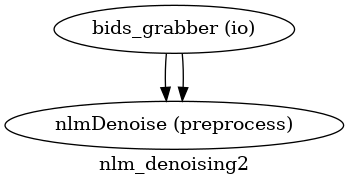

In [6]:
from IPython.display import Image, display
display(Image(filename=graph_img))

### Content of `pymialsrtk/interfaces/preprocess.py`

In [10]:
# %load '/opt/conda/envs/pymialsrtk-env/lib/python3.7/site-packages/pymialsrtk/interfaces/preprocess.py'
# Copyright © 2016-2019 Medical Image Analysis Laboratory, University Hospital Center and University of Lausanne (UNIL-CHUV), Switzerland
#
#  This software is distributed under the open-source license Modified BSD.

""" PyMIALSRTK preprocessing interfaces
"""

import os

from glob import glob

from traits.api import *

import nibabel as nib

from nipype.utils.filemanip import split_filename
from nipype.interfaces.base import traits, isdefined, CommandLine, CommandLineInputSpec,\
    TraitedSpec, File, InputMultiPath, OutputMultiPath, BaseInterface, BaseInterfaceInputSpec

from pymialsrtk.interfaces.utils import run

class BtkNLMDenoisingInputSpec(BaseInterfaceInputSpec):
    bids_dir = Directory(desc='BIDS root directory',mandatory=True,exists=True)
    in_file = File(desc='Input image',mandatory=True)
    in_mask = File(desc='Input mask',mandatory=False)
    out_postfix = traits.Str("_nlm", usedefault=True)
    weight = traits.Float(0.1,desc='NLM weight (0.1 by default)')

class BtkNLMDenoisingOutputSpec(TraitedSpec):
    out_file = File(desc='Denoised image')

class BtkNLMDenoising(BaseInterface):

    input_spec = BtkNLMDenoisingInputSpec
    output_spec = BtkNLMDenoisingOutputSpec
    
    def _run_interface(self, runtime): 
        _, name, ext = split_filename(os.path.abspath(self.inputs.in_file))
        out_file = os.path.join(self.inputs.bids_dir, ''.join((name, self.inputs.out_postfix, ext)))
        print('out_file: {}'.format(out_file))

        if self.inputs.in_mask:
            cmd = 'btkNLMDenoising -i "{}" -m "{}" -o "{}" -b {}'.format(self.inputs.in_file,self.inputs.in_mask,out_file,self.inputs.weight)
        else:
            cmd = 'btkNLMDenoising -i "{}" -o "{}" -b {}'.format(self.inputs.in_file,out_file,self.inputs.weight)
        
        try:
            print('... cmd: {}'.format(cmd))
            run(self, cmd, env={}, cwd=os.path.abspath(self.inputs.bids_dir))
        except:
            print('Failed')
        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        _, name, ext = split_filename(os.path.abspath(self.inputs.in_file))
        outputs['out_file'] = os.path.join(self.inputs.bids_dir, ''.join((name, self.inputs.out_postfix, ext)))
        return outputs

class MultipleBtkNLMDenoisingInputSpec(BaseInterfaceInputSpec):
    bids_dir = Directory(desc='BIDS root directory',mandatory=True,exists=True)
    input_images = InputMultiPath(File(desc='files to be denoised', mandatory = True))
    input_masks = InputMultiPath(File(desc='mask of files to be denoised', mandatory = False))
    weight = traits.Float(0.1)
    out_postfix = traits.Str("_nlm", usedefault=True)
    
class MultipleBtkNLMDenoisingOutputSpec(TraitedSpec):
    output_images = OutputMultiPath(File())

class MultipleBtkNLMDenoising(BaseInterface):
    input_spec = MultipleBtkNLMDenoisingInputSpec
    output_spec = MultipleBtkNLMDenoisingOutputSpec

    def _run_interface(self, runtime):
        if len(self.inputs.input_images)>0:
            for input_image, input_mask in zip(self.inputs.input_images,self.inputs.input_masks):
                ax = BtkNLMDenoising(bids_dir = self.inputs.bids_dir, in_file = input_image, in_mask = input_mask, out_postfix=self.inputs.out_postfix, weight = self.inputs.weight)
                ax.run()
        else:
            for input_image in self.inputs.input_images:
                ax = BtkNLMDenoising(bids_dir = self.inputs.bids_dir, in_file = input_image, out_postfix=self.inputs.out_postfix, weight = self.inputs.weight)
                ax.run()
        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs['output_images'] = glob(os.path.abspath("*.nii.gz"))
        return outputs